# 🎓 Análise de Sentimento (Amazon Reviews 2023)

## 1. O Cenário
Você foi contratado para analisar o feedback dos clientes sobre produtos vendidos na Amazon em 2023. A empresa precisa entender automaticamente se um review textual é **Positivo** ou **Negativo**, pois o volume de dados é grande demais para leitura humana. O objetivo é treinar um modelo capaz de ler o texto e prever a satisfação do cliente.

## 2. O Dataset
Utilizaremos a base **Amazon Reviews 2023** ([Link](https://www.kaggle.com/datasets/ravirajbabasomane/amazon-reviews-2023)).

Para este projeto, vocês devem conhecer bem o dicionário de dados antes de iniciar:

1. **Rating:** A nota dada pelo usuário (escala de 1 a 5). Esta será a base para nossa variável target.

2. **Title:** Um resumo conciso do review. (Muitas vezes carrega o sentimento mais forte).

3. **Text:** A descrição textual detalhada da experiência do usuário. (Nossa principal feature).

4. **Images:** Imagens associadas ao produto (não utilizaremos para este desafio de NLP).

5. **ASIN (Amazon Standard Identification Number):** Identificador único do produto.

6. **Parent ASIN:** Identificador do produto "pai" (útil para agrupar variações do mesmo item).

7. **User ID:** Identificador único do avaliador.

8. **Timestamp:** Data e hora da postagem.

9. **Helpful Votes:** Contagem de quantas pessoas acharam aquele review útil.

10. **Verified Purchase:** Indicador booleano se o avaliador realmente comprou o item pela Amazon.
* **Atenção:** Esta base pode conter múltiplas categorias. Para este exercício, vocês têm liberdade para escolher alguns produtos ou trabalhar com uma amostragem aleatória de 50.000 a 100.000 linhas para garantir que o processamento em memória seja viável.

---


# **Etapa 1: Análise Exploratória de Dados (EDA)**

Carregando Pacotes e Baixando Base

In [28]:
import kagglehub
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Download latest version
path = kagglehub.dataset_download("ravirajbabasomane/amazon-reviews-2023")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'amazon-reviews-2023' dataset.
Path to dataset files: /kaggle/input/amazon-reviews-2023


In [29]:
# Listar os arquivos na pasta para conferir o nome real
arquivos = os.listdir(path)
print("Arquivos encontrados:", arquivos)

# Pega o primeiro arquivo que termina com .csv (independente do nome)
nome_arquivo_csv = [f for f in arquivos if f.endswith('.csv')][0]
full_path = os.path.join(path, nome_arquivo_csv)

print(f"Lendo o arquivo correto: {full_path}")

# Agora sim, carrega o dataframe
df = pd.read_csv(full_path)
df.head()

Arquivos encontrados: ['Amazon_reviews_2023.csv']
Lendo o arquivo correto: /kaggle/input/amazon-reviews-2023/Amazon_reviews_2023.csv


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923,0,True
1,4,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.070,1,True
2,5,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,2020-05-16 21:41:06.052,2,True
3,1,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2022-01-28 18:13:50.220,0,True
4,5,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-30 10:02:43.534,0,True


In [30]:
# Selecionar colunas relevantes
cols_to_keep = ['title', 'text', 'rating', 'verified_purchase']

# Verifica se as colunas existem (alguns datasets usam nomes diferentes, ajuste se precisar)
if 'review_text' in df.columns:
    df.rename(columns={'review_text': 'text'}, inplace=True)

# Excluindo nulos
df = df[['title', 'text', 'rating', 'verified_purchase']].dropna(subset=['text', 'rating'])

# Análise de Verified Purchase
print("Distribuição de Ratings por Tipo de Compra:")
print(df.groupby('verified_purchase')['rating'].value_counts(normalize=True).unstack())

Distribuição de Ratings por Tipo de Compra:
rating                    1         2         3         4         5
verified_purchase                                                  
False              0.115037  0.049621  0.078444  0.158737  0.598161
True               0.148734  0.062589  0.080460  0.108376  0.599841


In [31]:
# Para este exercício, vamos manter apenas compras verificadas para garantir qualidade.
df = df[df['verified_purchase'] == True].copy()

# Criação da coluna Sentiment (Target)
# 4 e 5 -> Positivo (1)
# 1 e 2 -> Negativo (0)
# 3 -> Descartar (neutro/ambíguo)
df = df[df['rating'] != 3].copy()
df['sentiment'] = df['rating'].apply(lambda x: 1 if x > 3 else 0)

# Checar desbalanceamento
print("\nContagem de Classes (Sentimento):")
print(df['sentiment'].value_counts(normalize=True))


Contagem de Classes (Sentimento):
sentiment
1    0.770186
0    0.229814
Name: proportion, dtype: float64


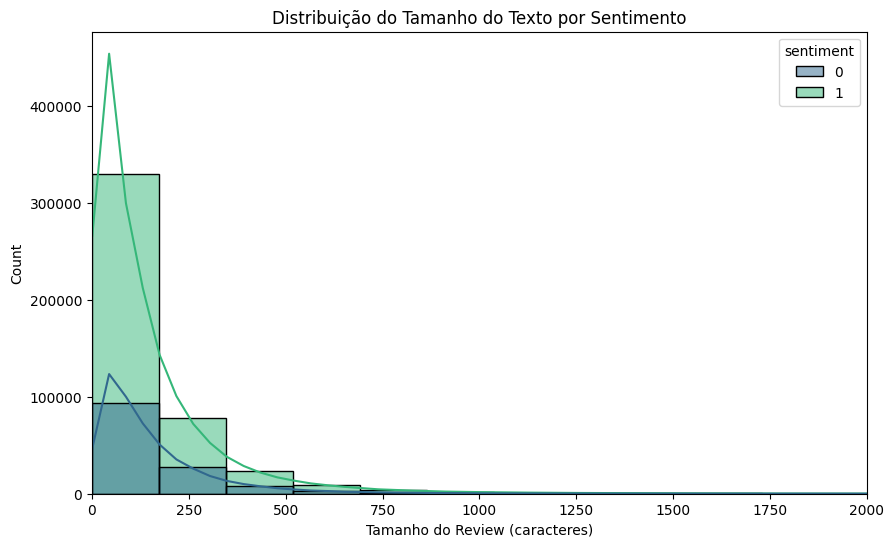

In [32]:
# Histograma: Tamanho do texto vs Sentimento
df['text_len'] = df['text'].astype(str).apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_len', hue='sentiment', bins=50, kde=True, palette='viridis')
plt.title('Distribuição do Tamanho do Texto por Sentimento')
plt.xlim(0, 2000) # Limitando o eixo X para melhor visualização
plt.xlabel('Tamanho do Review (caracteres)')
plt.show()

# **Etapa 2: Pré-processamento de Texto**

In [33]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Baixar recursos necessários do NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Normalização: Minúsculas
    text = str(text).lower()

    # Remoção de HTML tags (simples) e quebras de linha
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Remoção de Pontuação e Caracteres Especiais (mantendo apenas letras)
    text = re.sub(r'[^a-z\s]', '', text)

    # Remoção de Stopwords e Lematização
    words = text.split()
    cleaned_words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]

    return " ".join(cleaned_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [34]:
# Teste da função
exemplo = "I loved this product! <br> It's the best purchase ever."
print(f"Original: {exemplo}")
print(f"Limpo: {clean_text(exemplo)}")

Original: I loved this product! <br> It's the best purchase ever.
Limpo: loved product best purchase ever


# **Etapa 3 e 4: Vetorização e Modelagem**

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Divisão Treino e Teste
X = df['text'] # Usaremos o texto cru, pois o Pipeline aplicará a limpeza
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Criação do Pipeline (Naive Bayes)
# Utilizando a função 'clean_text' como o 'preprocessor' do CountVectorizer
pipeline_nb = Pipeline([
    ('vect', CountVectorizer(preprocessor=clean_text, min_df=5, max_features=10000)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

# Treinamento
print("Treinando modelo Naive Bayes... (isso pode levar um tempo dependendo do tamanho do dataset)")
pipeline_nb.fit(X_train, y_train)
print("Treinamento concluído.")

Treinando modelo Naive Bayes... (isso pode levar um tempo dependendo do tamanho do dataset)
Treinamento concluído.


# **Etapa 5: Avaliação e Iteração**

In [36]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

# --- Avaliação do Naive Bayes ---
y_pred_nb = pipeline_nb.predict(X_test)

print("=== Relatório de Classificação: Naive Bayes ===")
print(classification_report(y_test, y_pred_nb))



=== Relatório de Classificação: Naive Bayes ===
              precision    recall  f1-score   support

           0       0.91      0.52      0.66     26828
           1       0.87      0.99      0.93     89912

    accuracy                           0.88    116740
   macro avg       0.89      0.75      0.79    116740
weighted avg       0.88      0.88      0.86    116740



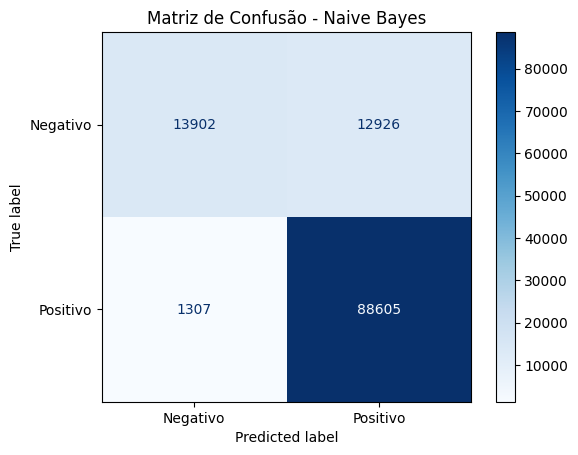

In [37]:
# Matriz de Confusão Visual
cm_nb = confusion_matrix(y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=['Negativo', 'Positivo'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão - Naive Bayes')
plt.show()



In [38]:
# --- Modelo Comparativo: Regressão Logística ---
pipeline_lr = Pipeline([
    ('vect', CountVectorizer(preprocessor=clean_text, min_df=5, max_features=10000)),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(max_iter=1000, random_state=42)),
])

print("\nTreinando modelo Logistic Regression...")
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

print("\n=== Relatório de Classificação: Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))


Treinando modelo Logistic Regression...

=== Relatório de Classificação: Logistic Regression ===
              precision    recall  f1-score   support

           0       0.86      0.76      0.80     26828
           1       0.93      0.96      0.95     89912

    accuracy                           0.91    116740
   macro avg       0.89      0.86      0.87    116740
weighted avg       0.91      0.91      0.91    116740



In [39]:
# Comparação rápida
acc_nb = pipeline_nb.score(X_test, y_test)
acc_lr = pipeline_lr.score(X_test, y_test)
print(f"\nAcurácia Naive Bayes: {acc_nb:.4f}")
print(f"Acurácia Logistic Regression: {acc_lr:.4f}")


Acurácia Naive Bayes: 0.8781
Acurácia Logistic Regression: 0.9146


## Conclusão

Após treinar e avaliar os dois modelos, Naive Bayes e Regressão Logística, com base nas métricas de acurácia, observamos que:

*   **Acurácia do Naive Bayes:** `0.8781`
*   **Acurácia da Regressão Logística:** `0.9146`

Com base nesses resultados, a **Regressão Logística (Logistic Regression) performou melhor** no dataset de teste, apresentando uma acurácia superior em comparação com o Multinomial Naive Bayes. Além da acurácia, o *Classification Report* da Regressão Logística também mostrou um equilíbrio melhor entre Precision, Recall e F1-Score para ambas as classes (0 - Negativo e 1 - Positivo), o que é crucial em cenários com classes desbalanceadas como este.